### Import all relevant dependencies

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from pathlib import Path
import yaml
from oed.experiments.experiment_library.latin_hypercube import LatinHypercube
from src.math_utils.blackbox_evaluation import evaluate_blackbox_region
from src.statistical_models.statistical_model_library.fcs_gaussian_noise_model import FCSGaussianNoiseModel
from src.utils.experiment_serialization import save_experiment_results
from src.visualization.plotting_functions import *
from src.math_utils.experiment_metrics import calculate_experiment_metrics
from src.math_utils.derivatives.numeric_derivative_calculator import NumericDerivativeCalculator
from src.model.hahn_stack_model import HahnStackModel
from src.math_utils.scaler.hahn_parameter_scaler import HahnParameterScaler
from src.model.parameter_set.hahn_parameter_set import HahnParameterSet

### Define the Experiment Metadata
- bounds for the free parameters
- operating conditions
- experiment repetitions
- true parameter set
- Experiment variance
- current values

Naming:
unscaled/ rescaled: actual physical values
scaled: scaled value between 0 & 1

In [2]:
path = "../data/config/oed_config_demo.yaml"

with open(path, "r") as f:
    config = yaml.safe_load(f)

number_designs = config["number_designs"] #Amount of LH Designs
n_rep = config["n_rep"] #Amount of experiment repetitions
n_current_values = config["n_current_values"] #Amount of individual current values
sigma = config["sigma"] #experiment variance (10mV variance in repeated experiments)

# lower and upper bounds for operating conditions
upper_bounds_operating_conditions = np.array(config["upper_bounds_operating_conditions"])
lower_bounds_operating_conditions = np.array(config["lower_bounds_operating_conditions"])

I_S_array = np.linspace(1, 480, n_current_values) # initialize applicable current array request

# select parameter values and names to be analyzed
unscaled_theta_true = np.array([list(HahnParameterSet().free_parameters.values())[i] for i in range(6)])
names_theta = [list(HahnParameterSet().free_parameters.keys())[i] for i in range(6)]

# initialize lower and upper bounds for free parameter values
unscaled_upper_bounds_free_params = np.array(config["unscaled_upper_bounds_free_params"], dtype=float)
unscaled_lower_bounds_free_params = np.array(config["unscaled_lower_bounds_free_params"], dtype=float)

# print metadata just to double-check, optional
print(names_theta, unscaled_lower_bounds_free_params, unscaled_theta_true, unscaled_upper_bounds_free_params)

['E_A', 'j_0_ref', 'r_el', 'D_CL_ref', 'D_GDL_ref', 'f_CL'] [1.e+03 1.e+02 1.e-07 1.e-09 1.e-07 1.e-02] [7.1477e+04 2.1308e+03 4.2738e-06 3.3438e-08 8.6266e-06 3.6693e-01] [1.e+05 1.e+04 1.e-05 1.e-07 1.e-05 1.e+00]


### Define Scaler and scale parameter values as well as  bounds of operating conditions and parameters
Scalers are saved in variable "scaler" and handed over to stack model.

In [3]:
scaler = HahnParameterScaler() # define scaler

# Stack bounds of free parameters
free_parameter_bounds = np.vstack([
    unscaled_lower_bounds_free_params,
    unscaled_upper_bounds_free_params
]).T

# Stack operating condition bounds (rows = condition, columns = [min, max])
operating_condition_bounds = np.vstack([
    lower_bounds_operating_conditions,
    upper_bounds_operating_conditions
]).T

# Determine current range for scaling
current_bounds = np.array([[I_S_array.min(), I_S_array.max()]])

scaled_theta_true = scaler.scale_theta(unscaled_theta_true, free_parameter_bounds)

# scale bounds of operating conditions to hand over for Experimental designs incl. LHC
scaled_upper_bounds = scaler.scale_params(upper_bounds_operating_conditions, operating_condition_bounds)
scaled_lower_bounds = scaler.scale_params(lower_bounds_operating_conditions, operating_condition_bounds)

# scale bounds of free parameters for initializing Model
scaled_lower_bounds_theta, _ = scaler.scale(unscaled_lower_bounds_free_params, free_parameter_bounds)
scaled_upper_bounds_theta, _ = scaler.scale(unscaled_upper_bounds_free_params, free_parameter_bounds)

# crlb_factor = unscaled_upper_bounds_free_params-unscaled_lower_bounds_free_params # offset for reformating the CRLB
# unit_factors = np.array([1e-4, 1e4, 1e4]) #([1e-3, 1e-4, 1e4, 1e4, 1e4, 1]) # factors to reformat the units from SI to applicable industry standard units# factors to reformat the units from SI to applicable industry standard units
# Print scaling results of scaled true parameters
print("Scaled theta:", scaled_theta_true)
print("Rescaled theta:", unscaled_theta_true)

Scaled theta: [0.71188889 0.20513131 0.42159596 0.32765657 0.86127273 0.36053535]
Rescaled theta: [7.1477e+04 2.1308e+03 4.2738e-06 3.3438e-08 8.6266e-06 3.6693e-01]


### Define the parametric function including handover of bounds

In [4]:
params = HahnParameterSet(free_parameters=names_theta)
hahn_fc_model = HahnStackModel(parameter_set=params) #Instanciate the generic Hahn Model
calculator = NumericDerivativeCalculator(hahn_fc_model, scaler) #Instanciate the derivation calculator function

#Initialize statistical model function
statistical_model = FCSGaussianNoiseModel(model_function=hahn_fc_model,
                                          der_function=calculator,
                                          lower_bounds_x=scaled_lower_bounds,
                                          upper_bounds_x=scaled_upper_bounds,
                                          lower_bounds_theta=scaled_lower_bounds_theta,
                                          upper_bounds_theta=scaled_upper_bounds_theta,
                                          sigma=sigma,
                                          scaler = scaler,)

#Initialize blackbox function returning noised experiment results
def blackbox_model(x):
    return statistical_model.random(theta=scaled_theta_true, x=x)

### Calculate LH Designs
returns LH Object to be used in other experimental design calculations

In [5]:
LH = LatinHypercube(lower_bounds_design=lower_bounds_operating_conditions,
                    upper_bounds_design=upper_bounds_operating_conditions,
                    number_designs=number_designs)

print(LH.experiment)

[[2.11697813e+05 3.55868338e+02 1.38795263e+00]
 [2.65641521e+05 3.63959721e+02 1.35408284e+00]
 [1.95630955e+05 3.44520277e+02 1.53571198e+00]
 [1.91677068e+05 3.65344768e+02 1.88111519e+00]
 [2.62733424e+05 3.57988834e+02 1.42367850e+00]
 [2.45382903e+05 3.43419790e+02 1.68879481e+00]
 [2.96487801e+05 3.47529757e+02 1.60659248e+00]
 [2.39414825e+05 3.40147459e+02 1.80952412e+00]
 [2.16915396e+05 3.51619054e+02 1.73620831e+00]
 [2.80419663e+05 3.61401211e+02 1.56538099e+00]]


### Evaluate Cell Voltage for LH-Designs with repetitions
Execute Experimental designs from LH experiments.


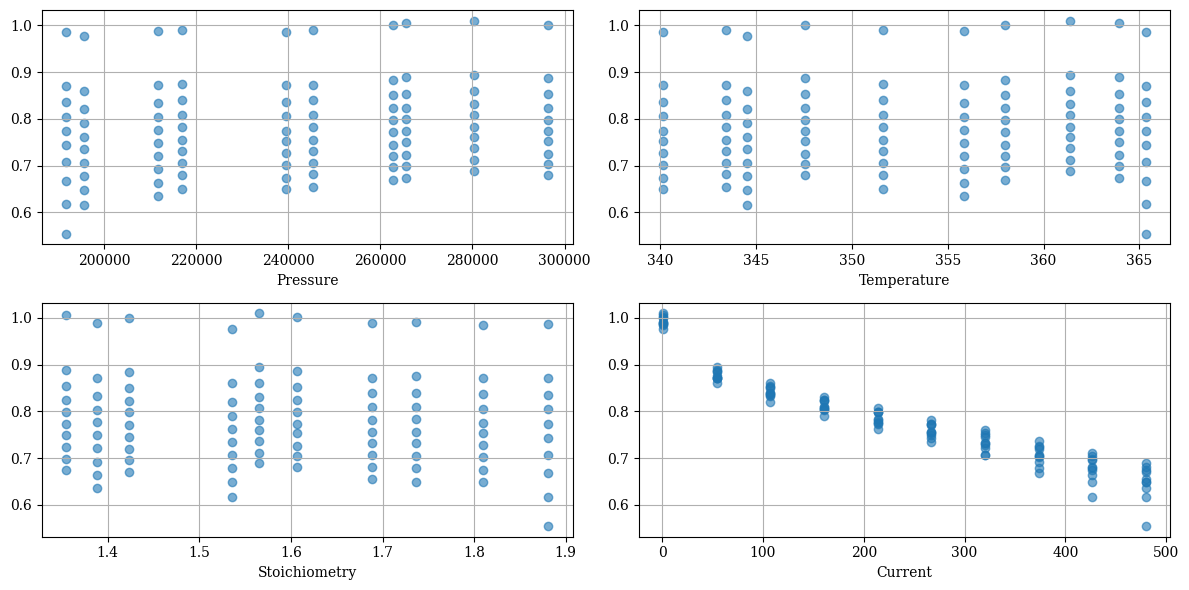

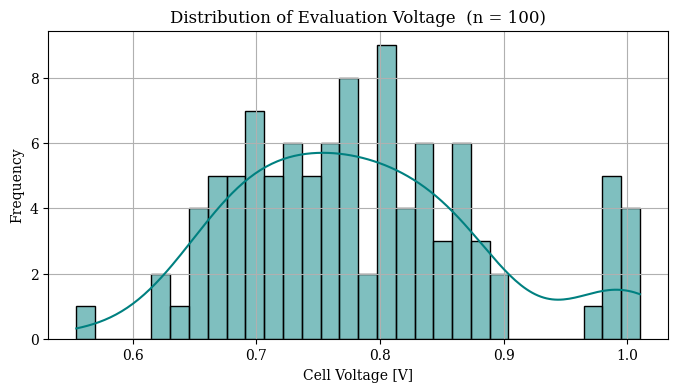

In [6]:
# Experiment execution with Current request and noised repetitions, returning y = calculated cell voltages, and x = full array of experiments incl. current values. Len of the returned array is number_designs * n_current_values * n_rep
evaluation_LH_experiment, x_LH_design = evaluate_blackbox_region(blackbox_model, LH.experiment, I_S_array, repetitions=n_rep)

# Plot results form experiment evaluation
plot_blackbox_evaluation(x_LH_design, evaluation_LH_experiment, input_labels=["Pressure", "Temperature", "Stoichiometry", "Current"])

### Calculate and plot metrics of LH-Designs
Calculates different kinds of metrics and prints them out directly for analysis.

In [7]:
# return array of operating conditions with number_designs * n_current_values (no repetitions)
_, x0_LH_design = evaluate_blackbox_region(blackbox_model, LH.experiment, I_S_array)

# calculate experiment metrics
(FIM_LH_experiment,
 det_FIM_LH_experiment,
 diagonal_CRLB_LH_experiment,
 CRLB_LH_experiment,
 std_LH_experiment) = calculate_experiment_metrics(statistical_model, scaled_theta_true, x0_LH_design)

In [8]:
# print experiment metrics
print(f"total amount of LH designs with current and repetitions: {len(x_LH_design)}") # number_designs * n_current_values * n_rep, just to double-check
print(f"total amount of LH designs with current: {len(x0_LH_design)}") # number_designs * n_current_values, just to double-check
print(f"FIM LH experiment:\n {FIM_LH_experiment}")
print(f"determinant of FIM:\n {det_FIM_LH_experiment}")
print("CRLB of Latin Hypercube experiment at initial theta: \n",
      diagonal_CRLB_LH_experiment)
print("Relative std of Latin Hypercube experiment at initial theta: \n",
      std_LH_experiment)

total amount of LH designs with current and repetitions: 100
total amount of LH designs with current: 100
FIM LH experiment:
 [[ 4.44504281e+04 -5.22892043e+03  4.35309307e+03  1.93395664e+03
   5.93982483e+03 -1.88974562e+02]
 [-5.22892043e+03  1.42004063e+06 -1.18219592e+06  6.59135876e+05
   1.68573183e+05  3.03727563e+05]
 [ 4.35309307e+03 -1.18219592e+06  1.38182599e+06 -8.21002594e+05
  -2.23164693e+05 -3.63743072e+05]
 [ 1.93395664e+03  6.59135876e+05 -8.21002594e+05  5.51825688e+05
   1.60527753e+05  2.29044960e+05]
 [ 5.93982483e+03  1.68573183e+05 -2.23164693e+05  1.60527753e+05
   5.04815587e+04  6.47422273e+04]
 [-1.88974562e+02  3.03727563e+05 -3.63743072e+05  2.29044960e+05
   6.47422273e+04  9.86396307e+04]]
determinant of FIM:
 5.0564792714009646e+26
CRLB of Latin Hypercube experiment at initial theta: 
 [3.15655666e-05 2.83510803e-06 1.37389019e-04 1.86946384e-04
 8.06033003e-04 5.04660448e-03]
Relative std of Latin Hypercube experiment at initial theta: 
 [0.00789214 

### Save LH-Designs as CSV

In [ ]:
x_array = np.array(x_LH_design)
eval_array = np.array(evaluation_LH_experiment).reshape(-1, 1)  # Reshape to (N, 1)
# Concatenate x & y column-wise --> save all experiments with repetitions and evaluations
combined_array = np.hstack((x_array, eval_array))

root = Path.cwd().parent   # this will be oed_fuel_cell_model/
data_path = root / "data" / "experimental_designs" / "lhc"
data_path.mkdir(parents=True, exist_ok=True)

save_experiment_results(combined_array, data_path / f"lhc.csv")

### Plot Operating conditions defined in the LHC

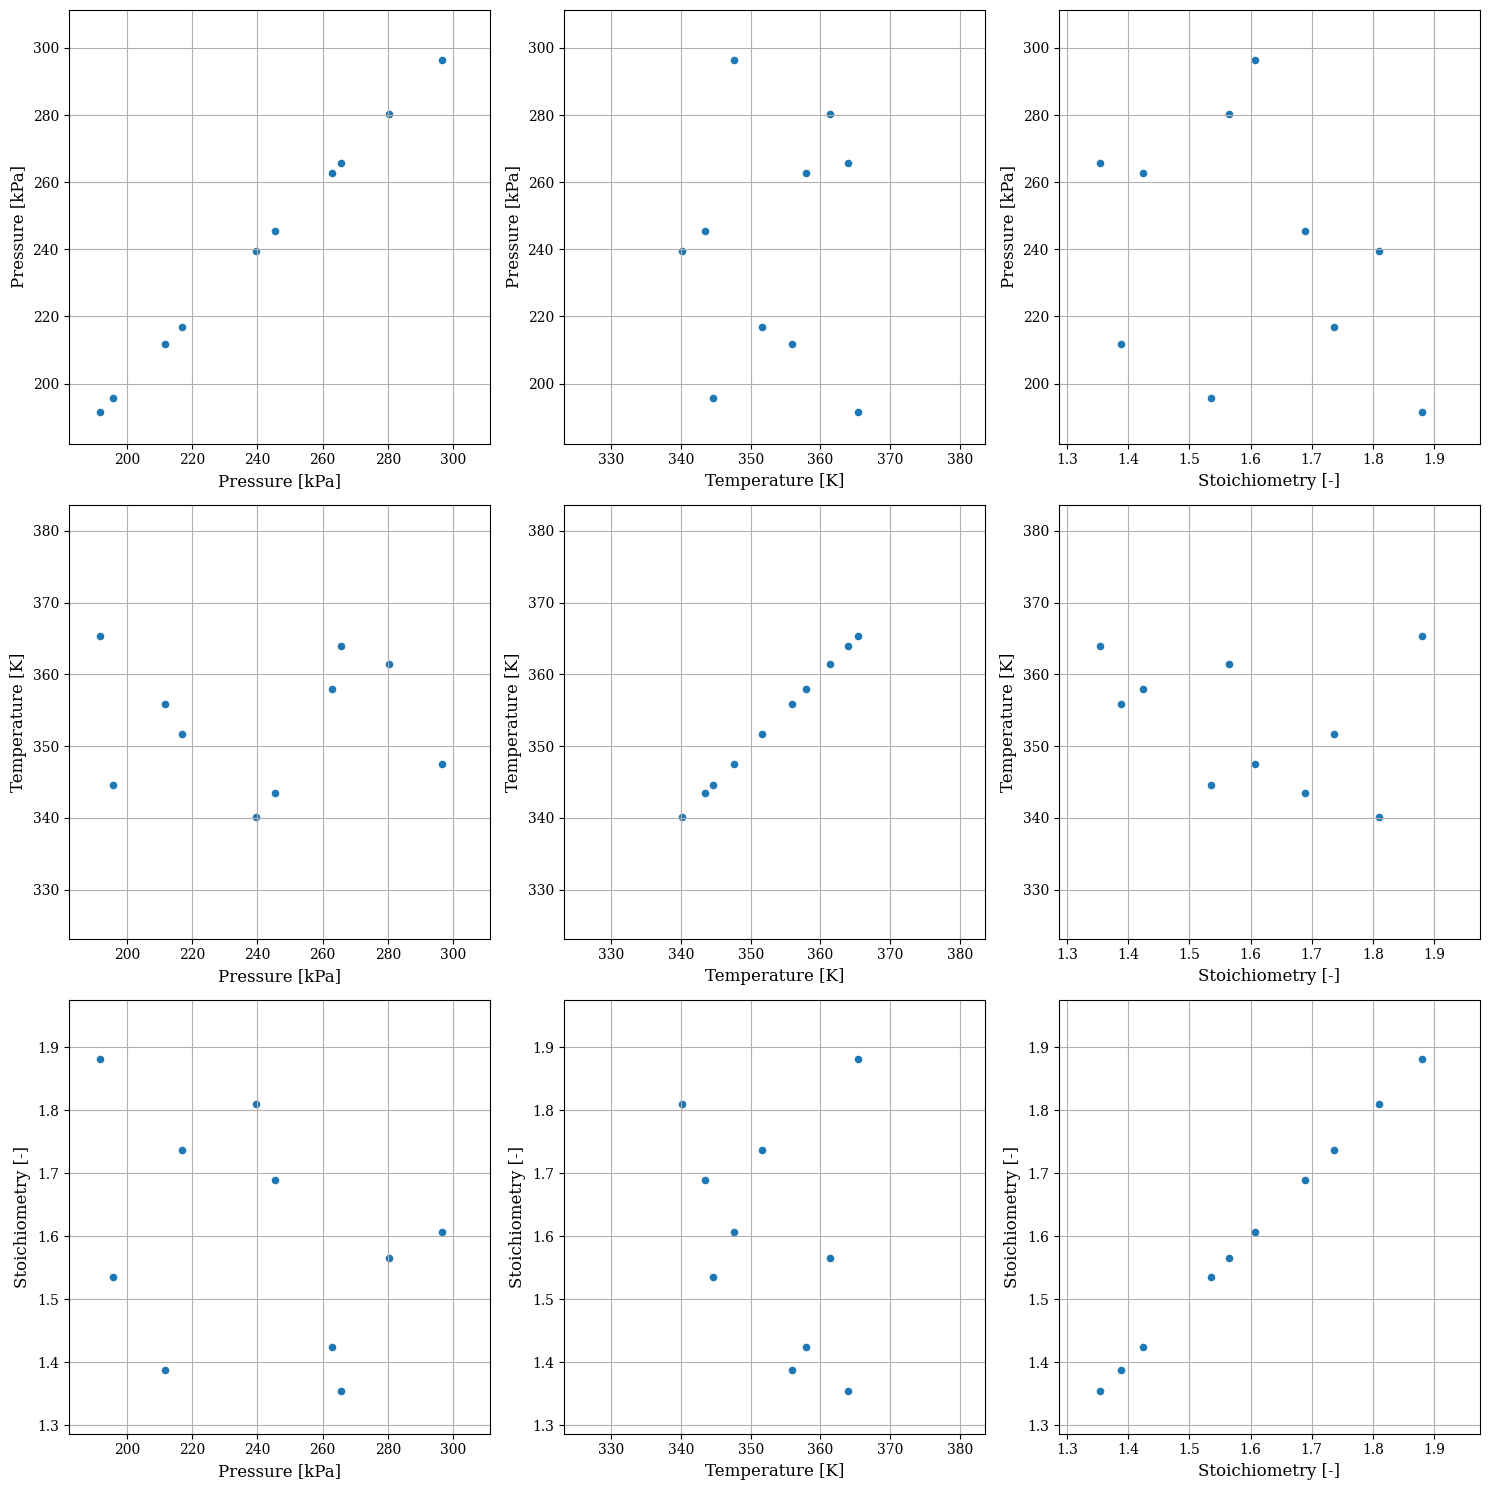

In [10]:
opCons = ["Pressure [kPa]", "Temperature [K]", "Stoichiometry [-]"]

plot_experiment_matrix([LH.experiment], opCons)